In [ ]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
path_to_data = '../../data' #'/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path_to_data, 'audio_features.tsv')
path_playlists = os.path.join(path_to_data, 'playlists.tsv')
path_tracks = os.path.join(path_to_data, 'tracks.tsv')

In [ ]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [ ]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [ ]:
pd_full.shape

(86400, 27)

In [ ]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [ ]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [ ]:
pd_full['available_markets'] = pd_full['available_markets'].apply(lambda x : x[1:-1].split(', '))
pd_full['count_available_markets'] = pd_full['available_markets'].apply(lambda x : len(x))

In [ ]:
pd_full.shape

(86350, 28)

## content filtering

* **Thuộc tính**: lấy toàn bộ các thuộc tính số (numeric features) của các track làm đặc trưng.
* **Mô tả ý tưởng**:
    * Tính **K** tracks trong tập hợp tất cả các tracks (trừ những seed tracks) có khoảng cách cosine (cosine similarity) gần nhất với từng seed track, ta được tập **N x K** tracks.
    * Sort các tracks vừa tìm được theo tần suất xuất hiện và chọn **K** tracks xuất hiện nhiều nhất làm kết quả dự đoán.

### create test-cases

In [ ]:
fraction = 3
nums_playlists_test = 100

track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [ ]:
all_playlistID_for_tests = list(track_id_test.keys())

In [ ]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
pd_full_tests = pd_full_tests.reset_index(drop = True)
pd_full_tests_copy = pd_full_tests.copy()

In [ ]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

In [ ]:
pd_full_tests_copy.shape

(4917, 15)

### Modeling

In [ ]:
# Standardizing the data
scaler = MinMaxScaler()
scaler.fit(pd_full_tests_copy)
df_full_scaled = scaler.transform(pd_full_tests_copy)

df_full_cosine = pd.DataFrame(cosine_similarity(df_full_scaled))

In [ ]:
df_full_cosine.shape

(4917, 4917)

In [ ]:
def generate_radio_content_filtering_cosineMetric(tracks, cosine_df, info_df, n_pred = 10):
    recs = []
    recs_id = []
    for t in tracks:
      index = info_df.index[info_df['track_id'] == t][0]
      similarities = cosine_df.iloc[:, index].sort_values(ascending=False)
      final_indices = list(similarities[1:(n_pred + 1)].index)
      rec_songs = info_df[['track_name','track_id']].iloc[final_indices]
      recs.extend(rec_songs['track_name'].values)
      recs_id.extend(rec_songs['track_id'].values)

    preds = collections.Counter(recs).most_common(n_pred)
    pred_titles = [p[0] for p in preds]

    preds_id = collections.Counter(recs_id).most_common(n_pred)
    pred_titles_id = [p[0] for p in preds_id]

    return pred_titles, pred_titles_id

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [ ]:
playlists_to_test = all_playlistID_for_tests[0]

In [ ]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [ ]:
track_name_result, track_id_result = generate_radio_content_filtering_cosineMetric(track_id_test[playlists_to_test], df_full_cosine, pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]))

In [ ]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['The Business', 'Head Shoulders Knees & Toes (feat. Norma Jean Martine)', 'The Business', 'Head Shoulders Knees & Toes (feat. Norma Jean Martine)', 'The Business', 'Head Shoulders Knees & Toes (feat. Norma Jean Martine)', 'The Business', 'The Business', 'The Business', 'The Business', 'The Business', 'The Business', 'The Business', 'The Business', 'The Business', 'The Business', 'The Business', 'The Business', 'Head Shoulders Knees & Toes (feat. Norma Jean Martine)', 'The Business', 'Head Shoulders Knees & Toes (feat. Norma Jean Martine)', 'Save My Life (feat. Lovespeake)', 'Paul Is Dead', 'Astronomia (Never Go Home)', 'Top Down', 'Up All Night (feat. Afrojack)', 'Like A Prayer', 'The Business', 'Head Shoulders Knees & Toes (feat. Norma Jean Martine)', 'No Therapy', "Somebody's Watching Me", 'The Business', 'Head Shoulders Knees & Toes (feat. Norma Jean Martine)', 'Save My Life (feat. Lovespeake)', 'Up All Night (feat. Afrojack)', 'Like A Prayer', 'The Business', 'Head S

**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [ ]:
def test_multi_feats(pd_playlists, pd_full, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  pd_full_tests_copy = pd_full_tests.copy()
  omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
  pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

  scaler = MinMaxScaler()
  scaler.fit(pd_full_tests_copy)
  df_full_scaled = scaler.transform(pd_full_tests_copy)

  df_full_cosine = pd.DataFrame(cosine_similarity(df_full_scaled))

  for each_playlist in all_playlistID_for_tests:
    track_name_result, track_id_result = generate_radio_content_filtering_cosineMetric(track_id_test[each_playlist], df_full_cosine, pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]))

    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [ ]:
r_score = test_multi_feats(pd_playlists, pd_full, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

Average R precision: 0.11464332845768702
Max R precision: 0.5375


**Test model trên những fraction khác nhau**:

Fraction là tỷ lệ bài hát hiện có trong mỗi playlist, ta dựa vào chúng để đề xuất các bài hát còn lại, ví dụ playlist có 100 bài hát, ta dùng 1/5 số đó (20 bài hát) để dựa vào đó đề xuất 80 bài hát còn lại.

Fraction có giá trị càng bé hoặc càng lớn thì tỷ lệ đề xuất trúng càng thấp.

Ở đây ta test model với các fraction lần lượt là 2 - 10, tức là trong một playlist có 100 bài hát thì ta sẽ dùng 50, 100/3, 25, ..., 10 bài hát đầu tiên để đề xuất số bài hát còn lại.

In [ ]:
fraction_to_test = list(np.arange(2, 11))

result_mean = {}
result_max = {}

for fraction in fraction_to_test:
  r_score = test_multi_feats(pd_playlists, pd_full, fraction = fraction, nums_playlists_test = 100)
  result_mean[fraction] = np.mean(r_score)
  result_max[fraction] = np.max(r_score)
  print('-'*30)
  print(f'fraction {fraction}:')
  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score))) 
  print('-'*30)

------------------------------
fraction 2:
Average R precision: 0.08279613046007418
Max R precision: 0.4
------------------------------
------------------------------
fraction 3:
Average R precision: 0.12975620148514105
Max R precision: 0.43283582089552236
------------------------------
------------------------------
fraction 4:
Average R precision: 0.11185777447831698
Max R precision: 0.64
------------------------------
------------------------------
fraction 5:
Average R precision: 0.1274360943015663
Max R precision: 0.6794871794871795
------------------------------
------------------------------
fraction 6:
Average R precision: 0.11056807468389904
Max R precision: 0.47619047619047616
------------------------------
------------------------------
fraction 7:
Average R precision: 0.1483586907604601
Max R precision: 0.6428571428571429
------------------------------
------------------------------
fraction 8:
Average R precision: 0.13592241297777125
Max R precision: 0.7222222222222222
---

In [ ]:
print(f'Mean Average R precision over all fractions: {np.mean(list(result_mean.values()))}')
print(f'Mean Max R precision over all fractions: {np.mean(list(result_max.values()))}')

Mean Average R precision over all fractions: 0.11843586382588629
Mean Max R precision over all fractions: 0.5450245276254765


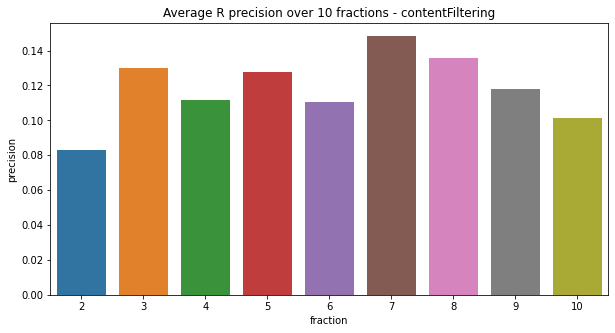

In [ ]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_mean.keys()), y=list(result_mean.values()))

_ = ax.set_title('Average R precision over 10 fractions - contentFiltering')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/contentFiltering_average_R_precision.png', bbox_inches = 'tight')

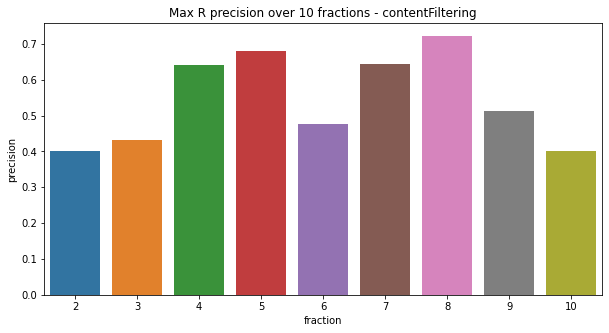

In [ ]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_max.keys()), y=list(result_max.values()))

_ = ax.set_title('Max R precision over 10 fractions - contentFiltering')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/contentFiltering_max_R_precision.png', bbox_inches = 'tight')

In [149]:
result = []

for keys in result_mean:
  result.append({'mean' : result_mean[keys]})

i = 0
for keys in result_max:
  result[i]['max'] = result_max[keys]
  result[i]['fraction'] = i + 2
  i = i + 1

result

[{'fraction': 2, 'max': 0.4, 'mean': 0.08279613046007418},
 {'fraction': 3, 'max': 0.43283582089552236, 'mean': 0.12975620148514105},
 {'fraction': 4, 'max': 0.64, 'mean': 0.11185777447831698},
 {'fraction': 5, 'max': 0.6794871794871795, 'mean': 0.1274360943015663},
 {'fraction': 6, 'max': 0.47619047619047616, 'mean': 0.11056807468389904},
 {'fraction': 7, 'max': 0.6428571428571429, 'mean': 0.1483586907604601},
 {'fraction': 8, 'max': 0.7222222222222222, 'mean': 0.13592241297777125},
 {'fraction': 9, 'max': 0.5116279069767442, 'mean': 0.11781302178353915},
 {'fraction': 10, 'max': 0.4, 'mean': 0.10141437350220862}]

In [150]:
df_result = pd.DataFrame(result)
df_result.to_csv('contentFiltering_result.csv', index = False)

**Nhận xét**: 

- Nhìn chung, theo thống kê, **content filtering** là phương pháp cho ra kết quả tốt nhất trong 5 models mà nhóm đã chạy. Có thể thấy qua giá trị trung bình **Average R precision** trên tất cả các fraction là 0.11843586382588629 (tức là ta đề xuất được đúng 1/10 phần còn lại của playlist) - một con số khá cao, hơn nữa giá trị trung bình của **Max R precision** trên tất cả các fraction là 0.5450245276254765 (tức là tính trung bình trên các fraction tỷ lệ playlist đề xuất chính xác nhiều nhất là 0.54, hơn một nửa playlist).

- Phương pháp **content filtering** cho ra kết quả khá ổn định với các fraction khác nhau (giá trị trung bình tỷ lệ đề xuất chính xác là 0.08 - 0.14).